In [27]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.linalg as dense_linalg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

In [31]:
x = np.linspace(-1, 1, 5)
y = np.linspace(-1, 1, 5)

mesh = np.meshgrid(x, y)
delta = x[1] - x[0]

In [32]:
r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

In [33]:
(np.gradient(np.gradient(A_z, axis=1), axis=1)* 1/delta**2
 + np.gradient(np.gradient(A_z, axis=0), axis=0) * 1/delta**2)

array([[  1.74955529e-05,   1.71852856e-04,   3.47193955e-04,
          1.71018617e-04,  -3.08553973e-05],
       [ -1.34772771e-04,   1.11610001e-05,   1.77513489e-04,
         -1.23400573e-05,  -2.29711350e-04],
       [ -2.89087670e-04,  -1.52743307e-04,   3.14383240e-06,
         -1.99532912e-04,  -4.31235608e-04],
       [ -1.34772771e-04,   1.11610001e-05,   1.77513489e-04,
         -1.23400573e-05,  -2.29711350e-04],
       [  1.74955529e-05,   1.71852856e-04,   3.47193955e-04,
          1.71018617e-04,  -3.08553973e-05]])

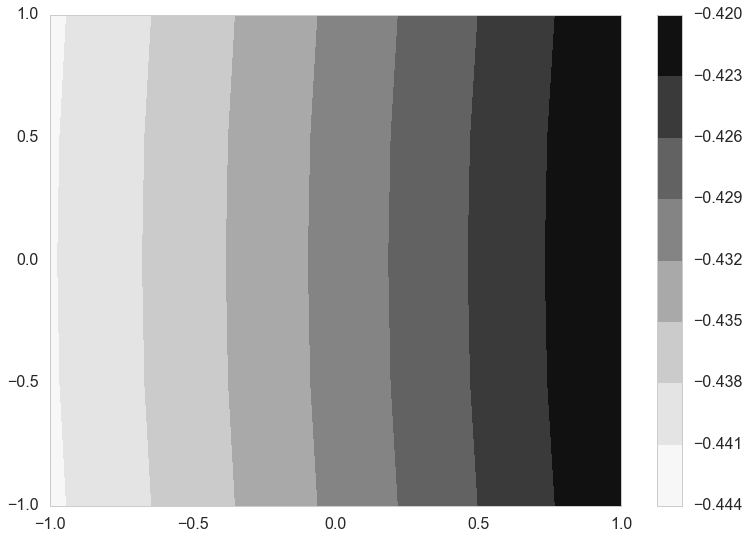

In [34]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], A_z[:,:])
plt.colorbar()

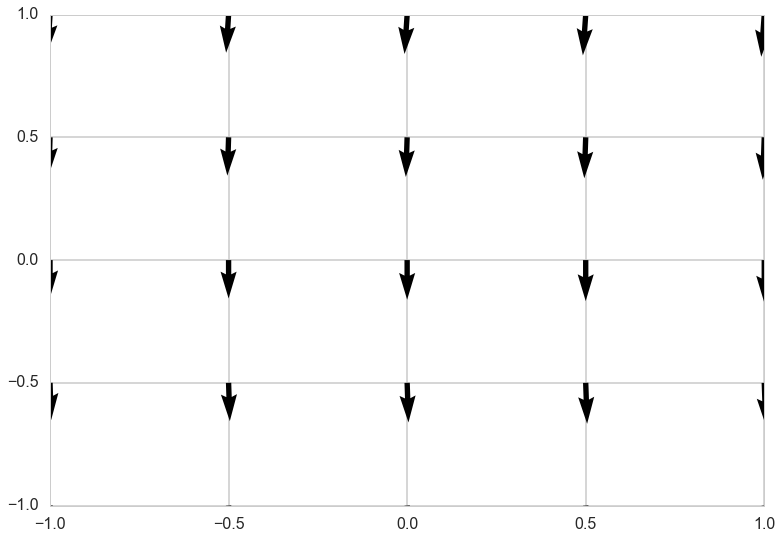

In [35]:
plt.quiver(mesh[0][:,:], mesh[1][:,:], B_x[:,:], B_y[:,:])

In [36]:
def curl(vector, delta):
    vector_x_dx = np.gradient(vector[0], axis=1)*1./delta
    vector_x_dy = np.gradient(vector[0], axis=0)*1./delta
    
    vector_y_dx = np.gradient(vector[1], axis=1)*1./delta
    vector_y_dy = np.gradient(vector[1], axis=0)*1./delta
    
    vector_z_dx = np.gradient(vector[2], axis=1)*1./delta
    vector_z_dy = np.gradient(vector[2], axis=0)*1./delta
    
    curl_x = vector_z_dy
    curl_y = -vector_z_dx
    curl_z = vector_y_dx - vector_x_dy
    
    return [curl_x, curl_y, curl_z]

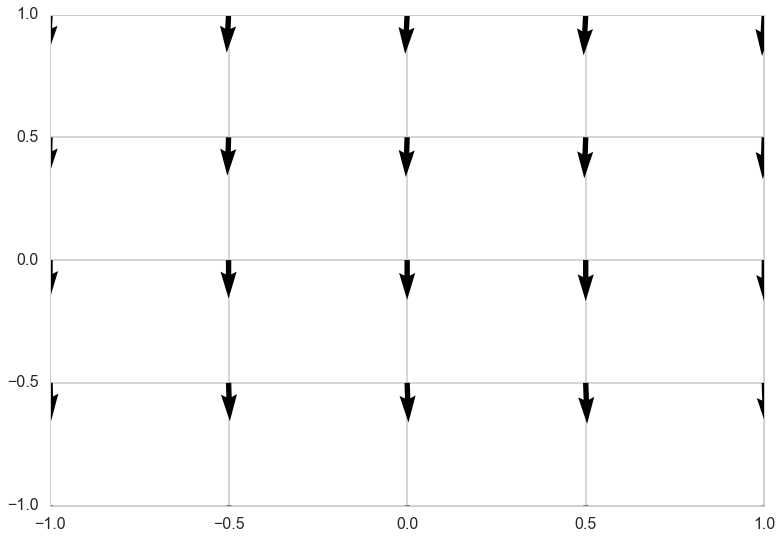

In [37]:
B_from_curl = curl([A_x, A_y, A_z], delta)
plt.quiver(mesh[0][:,:], mesh[1][:,:], B_from_curl[0][:,:], B_from_curl[1][:,:])

### Set up Laplace problem with Dirichlet boundaries

Build the matrix and b vector for the $Ax=b$ problem.

In [38]:
b_vector = np.zeros(A_z[1:-1, 1:-1].shape)
b_vector[0, :] += -A_z[0, 1:-1]
b_vector[:, 0] += -A_z[1:-1, 0]
b_vector[-1, :] += -A_z[-1, 1:-1]
b_vector[:, -1] += -A_z[1:-1, -1]
b_vector = b_vector.ravel()

In [39]:
A_z

array([[-0.44158144, -0.43654878, -0.43135247, -0.42598157, -0.42042399],
       [-0.44134887, -0.436301  , -0.43108795, -0.42569854, -0.42012046],
       [-0.4412712 , -0.43621824, -0.43099958, -0.42560398, -0.42001902],
       [-0.44134887, -0.436301  , -0.43108795, -0.42569854, -0.42012046],
       [-0.44158144, -0.43654878, -0.43135247, -0.42598157, -0.42042399]])

In [40]:
b_vector

array([ 0.87789765,  0.43135247,  0.84610202,  0.4412712 ,  0.        ,
        0.42001902,  0.87789765,  0.43135247,  0.84610202])

In [19]:
shape = mesh[0][1:-1, 1:-1].shape
matrix = sparse.diags((-4, 1, 1, 1, 1), 
                      (0, -1, 1, 
                        -(shape[1]), (shape[1])), 
                      shape=(shape[0]*shape[1], 
                             shape[0]*shape[1]))

In [21]:
matrix.toarray()

array([[-4.,  1.,  1.,  0.],
       [ 1., -4.,  1.,  1.],
       [ 1.,  1., -4.,  1.],
       [ 0.,  1.,  1., -4.]])

In [22]:
np.linalg.matrix_rank(matrix.toarray())

4

In [23]:
solution = dense_linalg.solve(matrix.toarray(), b_vector)
solution = solution.reshape(shape)

In [24]:
A_z_solved = np.array(A_z)
A_z_solved[1:-1, 1:-1] = solution

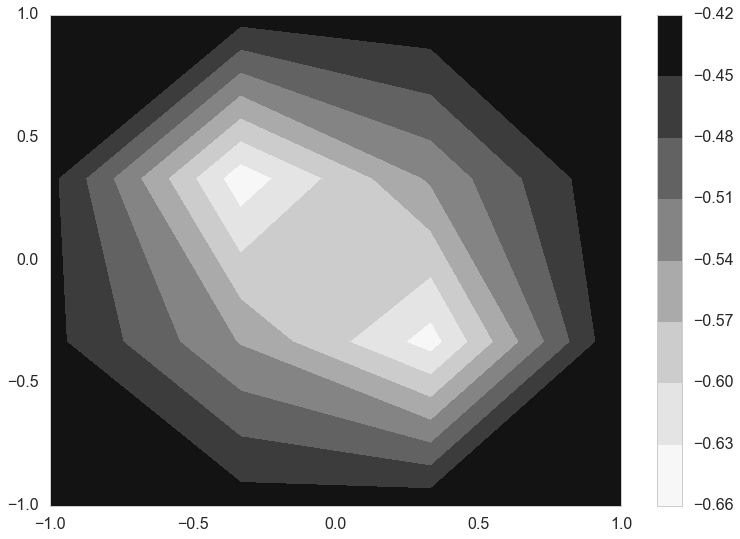

In [25]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], A_z_solved[:,:])
plt.colorbar()

# Try to make singular Neumann boundary matrix

In [43]:
shape = mesh[0][1:-1, 1:-1].shape
matrix = sparse.diags((-4, 1, 1, 1, 1), 
                      (0, -1, 1, 
                        -(shape[1]), (shape[1])), 
                      shape=(shape[0]*shape[1], 
                             shape[0]*shape[1]))

In [47]:
dense_matrix = matrix.toarray()
print dense_matrix
dense_matrix[0, 1] = 2.
dense_matrix[0, 3] = 2.
dense_matrix[-1, -2] = 2.
dense_matrix[-1, -4] = 2.
print dense_matrix

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  1. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  1.  0.  1.]
 [ 0.  0.  0.  1.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  1. -4.]]
[[-4.  2.  0.  2.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  1. -4.  1.  0.  1.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  1.  0.  1.]
 [ 0.  0.  0.  1.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  1.]
 [ 0.  0.  0.  0.  0.  2.  0.  2. -4.]]


In [50]:
np.dot(dense_matrix, dense_linalg.inv(dense_matrix))

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.11022302e-16,   5.55111512e-17,   0.00000000e+00],
       [ -1.38777878e-16,   1.00000000e+00,  -1.11022302e-16,
         -1.11022302e-16,  -2.77555756e-16,  -2.22044605e-16,
         -8.32667268e-17,  -1.66533454e-16,  -1.11022302e-16],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         -1.11022302e-16,   2.22044605e-16,   1.11022302e-16,
          5.55111512e-17,   0.00000000e+00,   5.55111512e-17],
       [ -1.11022302e-16,  -2.22044605e-16,  -1.11022302e-16,
          1.00000000e+00,  -2.22044605e-16,   0.00000000e+00,
         -1.11022302e-16,  -5.55111512e-17,  -5.55111512e-17],
       [  5.55111512e-17,   5.55111512e-17,   1.11022302e-16,
          1.11022302e-16,   1.00000000e+00,   2.22044605e-16,
          1.11022302e-16,   2.22044605e-16,   1.11022302e-16],
       [ -2.77555756e-17,   0.00000000e+00,   0.00000000e+00,
   